In [57]:
from random import shuffle, randint
import pandas as pd
import matplotlib.pyplot as plt

issue: only ace in initial hand will be counted as 11, maybe better way to do this is to count all aces as 11, then convert to 1 if causes hand to bust.

In [136]:
def create_new_shoe(n=6):
    shoe = [1,2,3,4,5,6,7,8,9,10,10,10,10]*4*n
    shuffle(shoe)
    return shoe, randint(60,80)

def deal(shoe, hand):
    card = shoe.pop()
    hand.append(card)

def deal_players_hands(shoe, players):
    for _ in range(2):
        for hand in players:
            deal(shoe, hand)

def clear_players_hands(players):
    for hand in players:
        while len(hand) > 0:
            hand.pop()
            
def play_dealer(shoe, dealer_hand):
    if 1 in dealer_hand:
        dealer_hand.remove(1); dealer_hand.append(11)
        
    while sum(dealer_hand) < 17:
        deal(shoe, dealer_hand)
        
        if sum(dealer_hand) > 21 and 11 in dealer_hand:
            dealer_hand.remove(11); dealer_hand.append(1)

def play_player_basic_strategy(shoe, dealer_hand, player_hand):
    dealer_visible_card = dealer_hand[0]
    
    if dealer_visible_card >= 7 or dealer_visible_card == 1:
        if 1 in player_hand:
            player_hand.remove(1); player_hand.append(11)
        while sum(player_hand) < 17:
            deal(shoe, player_hand)

            if sum(player_hand) > 21 and 11 in player_hand:
                player_hand.remove(11); player_hand.append(1)
    else:
        'do nothing'
        

def play_player_basic_double_down(shoe, dealer_hand, player_hand):
    dealer_visible_card = dealer_hand[0]
    dealer_bust_card = dealer_visible_card != 1 and dealer_visible_card < 7
    player_11_or_less = sum(player_hand) <= 11
    if dealer_visible_card >= 7 or dealer_visible_card == 1:
        if 1 in player_hand:
            player_hand.remove(1); player_hand.append(11)
        while sum(player_hand) < 17:
            deal(shoe, player_hand)

            if sum(player_hand) > 21 and 11 in player_hand:
                player_hand.remove(11); player_hand.append(1)
    else:
        'do nothing'
        
def play_player_basic_strategy_no_hit_ace(shoe, dealer_hand, player_hand):
    dealer_visible_card = dealer_hand[0]
    
    if dealer_visible_card >= 7:
        if 1 in player_hand:
            player_hand.remove(1); player_hand.append(11)
        while sum(player_hand) < 17:
            deal(shoe, player_hand)

            if sum(player_hand) > 21 and 11 in player_hand:
                player_hand.remove(11); player_hand.append(1)
    else:
        'do nothing'
        
def record_starting_hands(r, dealer_hand, player_hand):
    r['player_start_sum'].append(sum(player_hand))
    r['player_start_hand'].append(tuple(sorted(player_hand)))
    r['dealer_start_sum'].append(sum(dealer_hand))
    r['dealer_visible_card'].append(dealer_hand[0])
    r['dealer_start_hand'].append(tuple(sorted(dealer_hand)))

def record_ending_hands(r, dealer_hand, player_hand):
    if 11 in dealer_hand: dealer_hand.remove(11); dealer_hand.append(1)
    if 11 in player_hand: player_hand.remove(11); player_hand.append(1)
    r['dealer_end_hand'].append(tuple(sorted(dealer_hand)))
    r['dealer_end_sum'].append(sum(dealer_hand))
    if sum(dealer_hand) > 21: r['dealer_busted'].append(True)
    else: r['dealer_busted'].append(False)
    r['player_end_hand'].append(tuple(sorted(player_hand)))
    r['player_end_sum'].append(sum(player_hand))
    if sum(player_hand) > 21: r['player_busted'].append(True)
    else: r['player_busted'].append(False)
    
def score_game(r, dealer_hand, player_hand):
    player_sum, dealer_sum = sum(player_hand), sum(dealer_hand)
    if player_sum > 21:
        r['winner'].append('Dealer'); r['payout_multiplier'].append(-1)
    elif player_sum == 21:
        r['winner'].append('Player'); r['payout_multiplier'].append(1.5)
    elif dealer_sum > 21:
        r['winner'].append('Player'); r['payout_multiplier'].append(1)
    elif dealer_sum > player_sum:
        r['winner'].append('Dealer'); r['payout_multiplier'].append(-1)
    elif dealer_sum < player_sum:
        r['winner'].append('Player'); r['payout_multiplier'].append(1)
    else:
        r['winner'].append('Push'); r['payout_multiplier'].append(0)

def new_record():
    r = {'dealer_start_hand': [], 'dealer_start_sum': [], 
         'dealer_end_hand': [], 'dealer_end_sum': [], 
         'dealer_busted': [], 'dealer_visible_card': [],
         'player_start_hand': [], 'player_start_sum': [], 
         'player_end_hand': [], 'player_end_sum': [], 
         'player_busted': [], 'winner': [], 'payout_multiplier': [],
         'money_count': []}
    return r

def game_simulation(player_strategy, number_of_rounds=1000000, number_of_decks=8):
    # initialize game/records variables
    r = new_record()
    records = pd.DataFrame(r)
    dealer_hand, player_hand = [], []
    
    # create new shoe
    shoe, new_shoe_trigger = create_new_shoe(number_of_decks)
    round_count = 0
    r = new_record()

    # play round
    while round_count < number_of_rounds:
        # deal hands to player and dealer
        deal_players_hands(shoe, [dealer_hand, player_hand])

        # record starting hands for player and dealer
        record_starting_hands(r, dealer_hand, player_hand)

        # play player_strategy if dealer doesn't have blackjack
        if sum(dealer_hand) != 21:
            player_strategy(shoe, dealer_hand, player_hand)

        # only play dealer if player has not busted
        if sum(player_hand) <= 21: play_dealer(shoe, dealer_hand)

        # score game
        score_game(r, dealer_hand, player_hand)
        r['money_count'].append(None)

        # record ending hands
        record_ending_hands(r, dealer_hand, player_hand)

        # if end shoe is near, shuffle and make new shoe
        if len(shoe) < new_shoe_trigger:
            shoe, new_shoe_trigger = create_new_shoe(8)

        # clear player hands and record
        clear_players_hands([dealer_hand, player_hand])
        round_count += 1

    # store and return records
    new_records = pd.DataFrame(r)
    return new_records

def game_simulation_betting(player_strategy, 
                            number_of_rounds=1000000, 
                            number_of_decks=8, 
                            starting_money=1000, 
                            bet_amount=25):
    # initialize game/records variables
    r = new_record()
    records = pd.DataFrame(r)
    dealer_hand, player_hand = [], []
    money_count = starting_money
    
    # create new shoe
    shoe, new_shoe_trigger = create_new_shoe(number_of_decks)
    round_count = 0
    r = new_record()

    # play round
    while round_count < number_of_rounds:
        # deal hands to player and dealer
        deal_players_hands(shoe, [dealer_hand, player_hand])

        # record starting hands for player and dealer
        record_starting_hands(r, dealer_hand, player_hand)

        # play player_strategy if dealer doesn't have blackjack
        if sum(dealer_hand) != 21:
            player_strategy(shoe, dealer_hand, player_hand)

        # only play dealer if player has not busted
        if sum(player_hand) <= 21: play_dealer(shoe, dealer_hand)

        # score game
        score_game(r, dealer_hand, player_hand)
                
        money_count += (bet_amount*r['payout_multiplier'][-1])
        r['money_count'].append(money_count)

        # record ending hands
        record_ending_hands(r, dealer_hand, player_hand)

        # if end shoe is near, shuffle and make new shoe
        if len(shoe) < new_shoe_trigger:
            shoe, new_shoe_trigger = create_new_shoe(8)

        # clear player hands and record
        clear_players_hands([dealer_hand, player_hand])
        round_count += 1

    # store and return records
    new_records = pd.DataFrame(r)
    return new_records

def calc_returns_percent(records):
    return round(records['payout_multiplier'].sum()/records['payout_multiplier'].count()*100,2)

In [189]:
test_betting = game_simulation_betting(play_player_basic_strategy, 100)

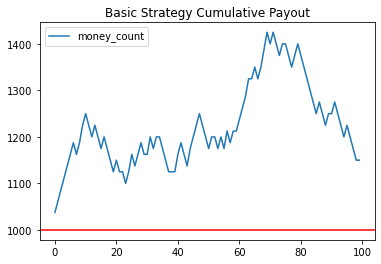

In [191]:
fig, ax = plt.subplots()
test_betting[['money_count']].plot(title='Basic Strategy Cumulative Payout', ax=ax)
plt.axhline(y=1000, color='r', linestyle='-')
plt.show()

## Game Simulation Analysis:

### Comparing hitting when dealer has Ace showing to not:

In [97]:
records = game_simulation(play_player_basic_strategy)
records['cumulative_payout'] = records['payout_multiplier'].cumsum()
records_no_hit_ace = game_simulation(play_player_basic_strategy_no_hit_ace)

In [98]:
print('Basic Strategy Returns Percent:', str(calc_returns_percent(records))+'%')
print('No Hit Dealer Ace Returns Percent:', str(calc_returns_percent(records_no_hit_ace))+'%')

Basic Strategy Returns Percent: -6.4%
No Hit Dealer Ace Returns Percent: -9.5%


One situation where I often forget what the best strategy is is when the dealer has an ace showing and checks and sees that it is not blackjack.  In this situation, the dealer has equal likelihood of having an ace through a 9 hidden, and looking below we can see that this comes out to an average hidden card value of 5.  Does this mean we should play as if the dealer has a 6 showing when we see an Ace and we know it's not blackjack?  Well, according to the simulation above not hitting until 17 or higher when the dealer shows an Ace and doesn't have Blackjack gives a 3% less return overall.  So no, we should treat the dealer having an Ace showing as if the dealer were showing a 7 or higher. 

In [99]:
dealer_ace_not_21 = records.query('dealer_visible_card == 1 & dealer_start_sum != 11')
print('When the dealer is showing an Ace, but does not have blackjack:')
print('Dealer Mean Hidden Card:', dealer_ace_not_21['dealer_start_sum'].mean() - 1)
print('Dealer Median Hidden Card:', dealer_ace_not_21['dealer_start_sum'].median() - 1)

When the dealer is showing an Ace, but does not have blackjack:
Dealer Mean Hidden Card: 5.005737441063415
Dealer Median Hidden Card: 5.0


In [100]:
dealer_ace = records.query('dealer_visible_card == 1')
print('Percentage of time dealer does not have Blackjack with Ace showing:')
print(str(round(dealer_ace_not_21.shape[0]/dealer_ace.shape[0]*100,2))+'%')

Percentage of time dealer does not have Blackjack with Ace showing:
69.03%


## Basic Strategy Cumulative Payout Analysis:

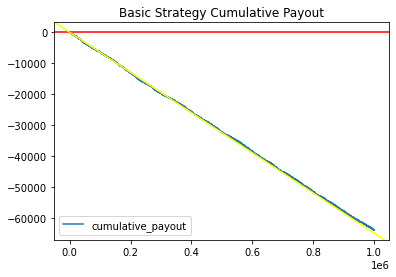

In [201]:
fig, ax = plt.subplots()
records[['cumulative_payout']].plot(title='Basic Strategy Cumulative Payout', ax=ax)
plt.axhline(y=0, color='r', linestyle='-')
plt.axline((0,0), slope=-0.065, color='yellow', label='axline')
plt.show()

In [193]:
records_1000 = game_simulation(play_player_basic_strategy, 1000)
records_1000['cumulative_payout'] = records_1000['payout_multiplier'].cumsum()

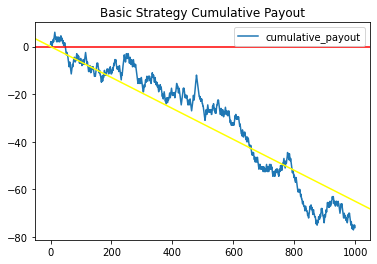

In [202]:
fig, ax = plt.subplots()
records_1000[['cumulative_payout']].plot(title='Basic Strategy Cumulative Payout', ax=ax)
plt.axhline(y=0, color='r', linestyle='-')
plt.axline((0,0), slope=-0.065, color='yellow', label='axline')
plt.show()

With no changing betting amounts, basic strategy has almost a linear descent at a rate of 6% decrease.  I would like to see how I can make this graph positive through changing betting strategies and gaming strategies.

In [230]:
records_100 = game_simulation(play_player_basic_strategy, 100)
records_100['cumulative_payout'] = records_100['payout_multiplier'].cumsum()

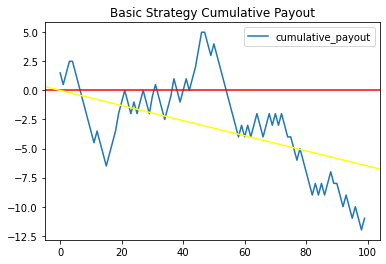

In [231]:
fig, ax = plt.subplots()
records_100[['cumulative_payout']].plot(title='Basic Strategy Cumulative Payout', ax=ax)
plt.axhline(y=0, color='r', linestyle='-')
plt.axline((0,0), slope=-0.065, color='yellow', label='axline')
plt.show()

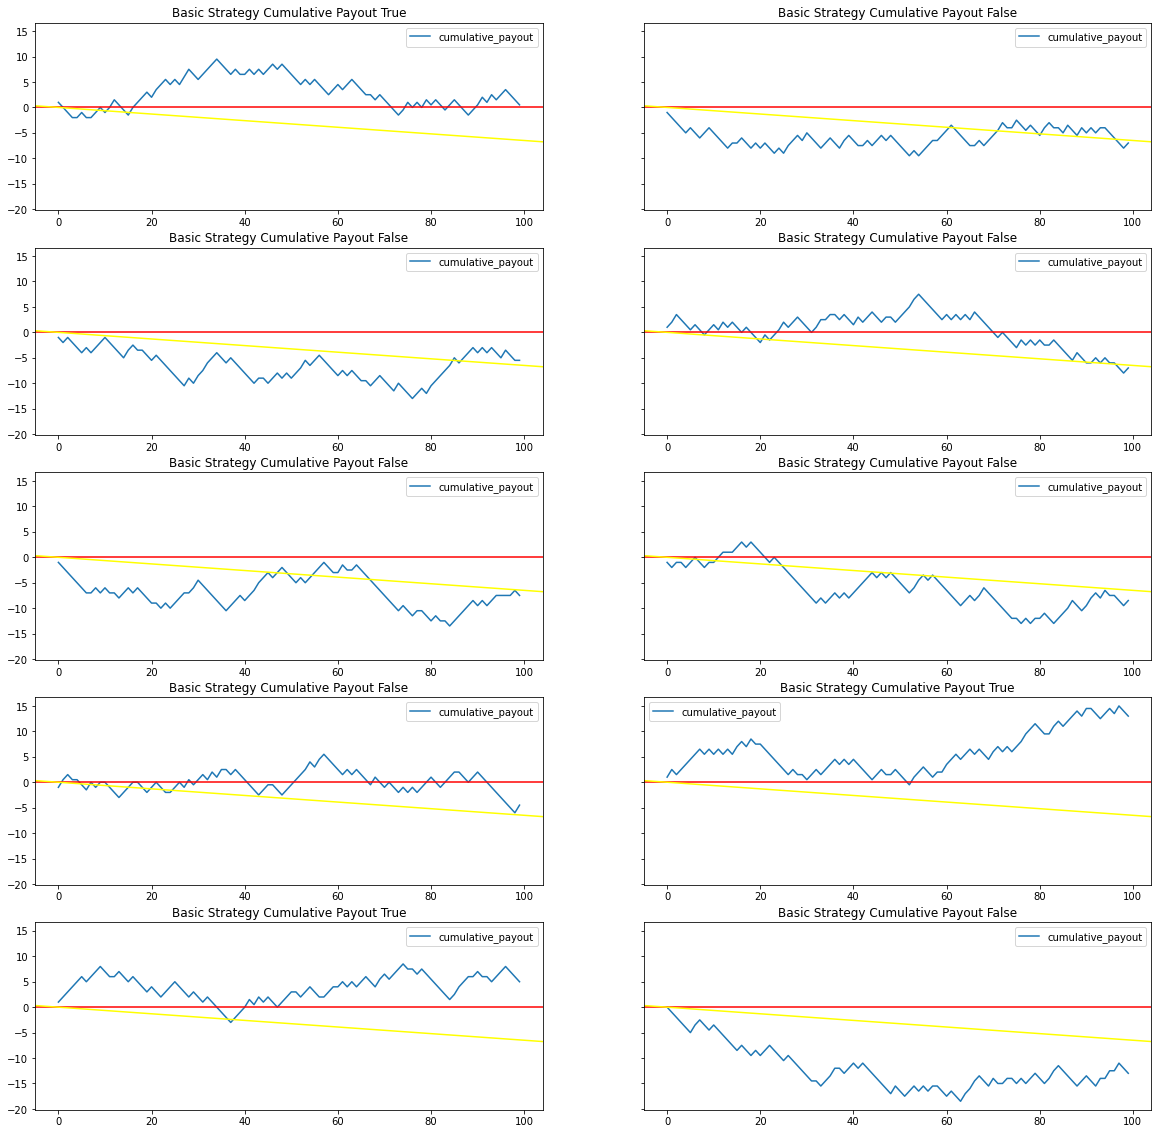

In [253]:
fig, axes = plt.subplots(5,2, figsize=(20, 20), sharey=True)
for ax in axes.flat:
    records_100 = game_simulation(play_player_basic_strategy, 100)
    records_100['cumulative_payout'] = records_100['payout_multiplier'].cumsum()
    title='Basic Strategy Cumulative Payout' + ' ' + str(records_100['cumulative_payout'][99] > 0)
    records_100[['cumulative_payout']].plot(title=title, ax=ax)
    ax.axhline(y=0, color='r', linestyle='-')
    ax.axline((0,0), slope=-0.065, color='yellow', label='axline')
plt.show()